# 02a. Exploring the impact of cyclones on vegetation: scene before and after cyclone

metadata blah

# Import libraries

In [1]:
#Import libraries 

%pylab notebook
import pandas as pd
import xarray as xr
from datetime import date, timedelta
import gdal
from gdal import *

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.animation as animation
from IPython.display import display
import ipywidgets as widgets
import rasterio

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [2]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/cyclone_repo/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [9]:
###User input: enter area of interest

lat_min = -20.267 #down
lat_max = -20.216 #up
lon_min = 148.534 #left
lon_max = 148.592 #right

#High Mt QLD
# lat_min = -20.375 #down
# lat_max = -20.340 #up
# lon_min = 148.757 #left
# lon_max = 148.806 #right

# lat_min = -20.385 #down
# lat_max = -20.326 #up
# lon_min = 148.916 #left
# lon_max = 148.984 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

##User input: enter the name of the area/region/place/location of interest, e.g. "Hamilton Island"
location_name = 'Mt Dryander QLD'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.80 

# No more "user requirements" just run the remaining cells

While the remaining cells do not require any changes, the user can edit code as required.

# Datacube query is completed

In [10]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2000-01-01'
end_of_epoch =  '2017-12-31'

#wavelengths/bands of interest are defined
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8', 
    'ls7',
    'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2017-12-31'), 'x': (148.534, 148.592), 'y': (-20.216, -20.267), 'crs': 'EPSG:4326'}


In [11]:
#Reformat variables

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime
location_name=location_name.replace(" ","_") #replace spaces with underscore

# Extract information from Open Data Cube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [12]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea':'land'}

In [13]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [14]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 35, x: 269, y: 257)
 Coordinates:
   * time     (time) datetime64[ns] 2003-08-02T23:41:36 2003-08-18T23:41:52 ...
   * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
   * x        (x) float64 1.714e+06 1.714e+06 1.714e+06 1.714e+06 1.714e+06 ...
 Data variables:
     green    (time, y, x) float64 296.0 296.0 296.0 352.0 352.0 352.0 296.0 ...
     red      (time, y, x) float64 236.0 236.0 282.0 282.0 328.0 282.0 236.0 ...
     nir      (time, y, x) float64 1.705e+03 1.705e+03 1.815e+03 2.034e+03 ...
     swir1    (time, y, x) float64 964.0 964.0 1.121e+03 1.239e+03 1.278e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 83, x: 269, y: 257)
 Coordinates:
   * time     (time) datetime64[ns] 2000-06-30T23:56:29.500000 ...
   * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
   * x     

In [15]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
nbar_clean = nbar_clean.sortby('time')
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [16]:
# #Remove 'product' data variable

# nbar_clean=nbar_clean.drop('product')

In [17]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 145, x: 269, y: 257)
Coordinates:
  * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
  * x        (x) float64 1.714e+06 1.714e+06 1.714e+06 1.714e+06 1.714e+06 ...
  * time     (time) datetime64[ns] 2000-06-30T23:56:29.500000 ...
Data variables:
    green    (time, y, x) float64 205.0 206.0 206.0 267.0 236.0 236.0 206.0 ...
    red      (time, y, x) float64 135.0 189.0 162.0 162.0 135.0 189.0 162.0 ...
    nir      (time, y, x) float64 2.473e+03 2.278e+03 2.473e+03 2.667e+03 ...
    swir1    (time, y, x) float64 839.0 803.0 839.0 944.0 979.0 909.0 698.0 ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1713675.00|\n| 0.00,-25.00,-2279200.00|\n| 0.00,...

# Landscape and NDVI of scene prior to cyclone

In [18]:
#Prepare imagery for scene before cyclone

rgb = nbar_clean.sel(time =start_of_event, method = 'pad').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


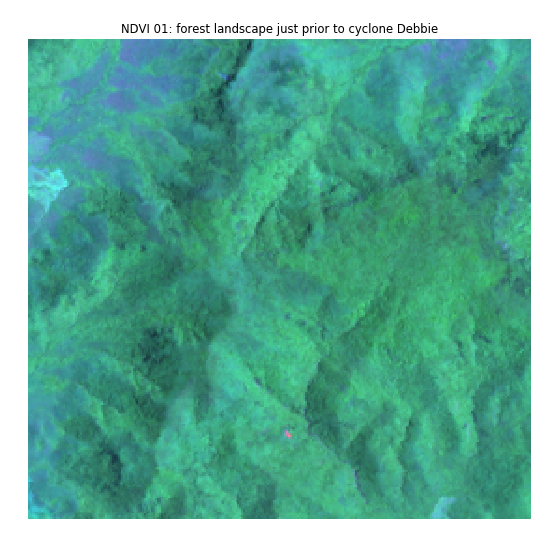

In [19]:
#Create image that shows landscape before cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('NDVI 01: ' + str(vegetation_type)+ ' landscape just prior to cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled, interpolation = 'nearest') #create image
plt.show() #show image

In [24]:
#Save figure
plt.savefig(str(output_folder)+'landscape_image01_'+str(cyclone_name)+'_'+str(location_name))

In [20]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

ndvi01= ndvi.sel(time =start_of_event, method = 'pad') #NDVI for scene just prior to cyclone

<IPython.core.display.Javascript object>


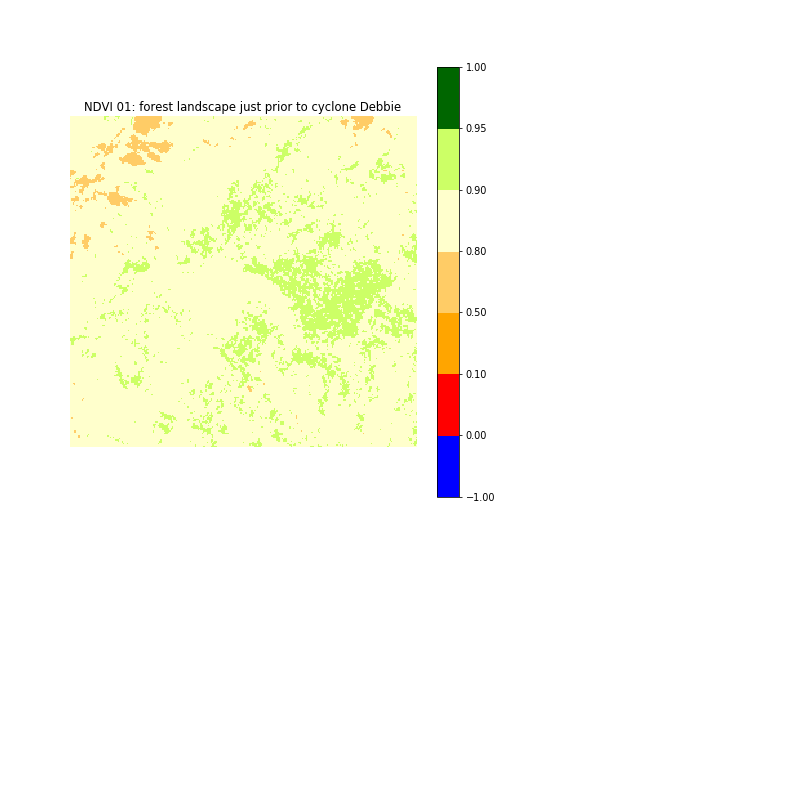

In [21]:
#Plot NDVI for scene prior to cyclone

#Controls for NDVI colour map
ndvi_cmap = mpl.colors.ListedColormap(['blue', 'red', 'orange', '#ffcc66','#ffffcc' , '#ccff66' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.5, 0.8, 0.9, 0.95, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Create plot
fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
plt.title('NDVI 01: ' + str(vegetation_type)+ ' landscape just prior to cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi01,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

In [25]:
#Save figure
plt.savefig(str(output_folder)+'NDVI01_'+str(cyclone_name)+'_'+str(location_name))

# Landscape and NDVI of scene after cyclone

In [26]:
#Prepare imagery for scene after cyclone
rgb02 = nbar_clean.sel(time =end_of_event, method = 'backfill').to_array(dim='color').sel(color=[
   'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


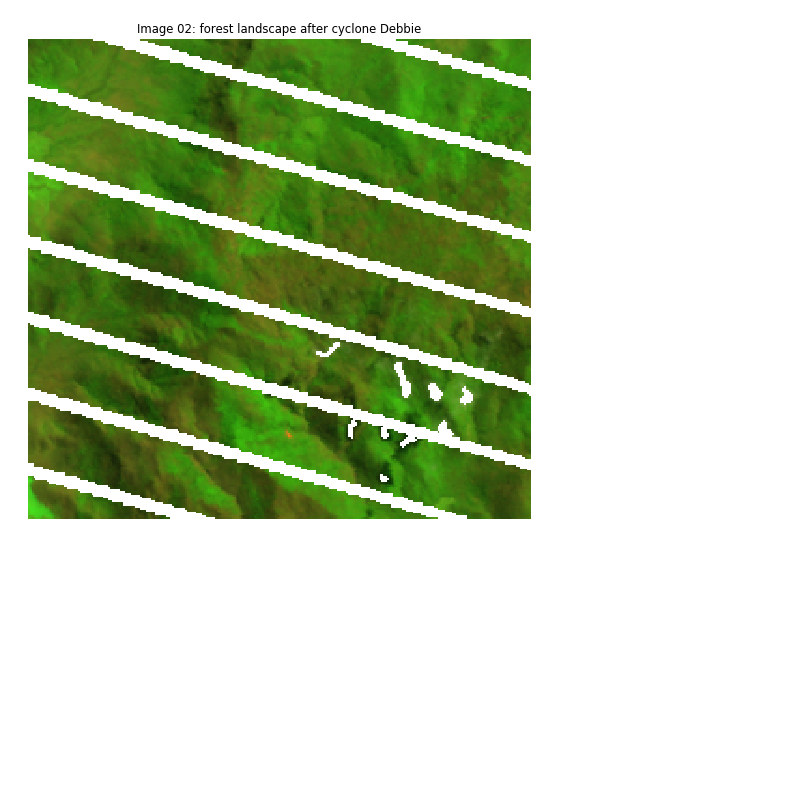

In [27]:
#Create image that shows landscape after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis
plt.title('Image 02: ' + str(vegetation_type)+ ' landscape after cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled02, interpolation = 'nearest') #create image
plt.show() #show image

In [28]:
#Save figure
plt.savefig(str(output_folder)+'landscape_image02_'+str(cyclone_name)+'_'+str(location_name))

In [29]:
#Select NDVI for scene after cyclone
ndvi02= ndvi.sel(time =end_of_event, method = 'backfill')

<IPython.core.display.Javascript object>


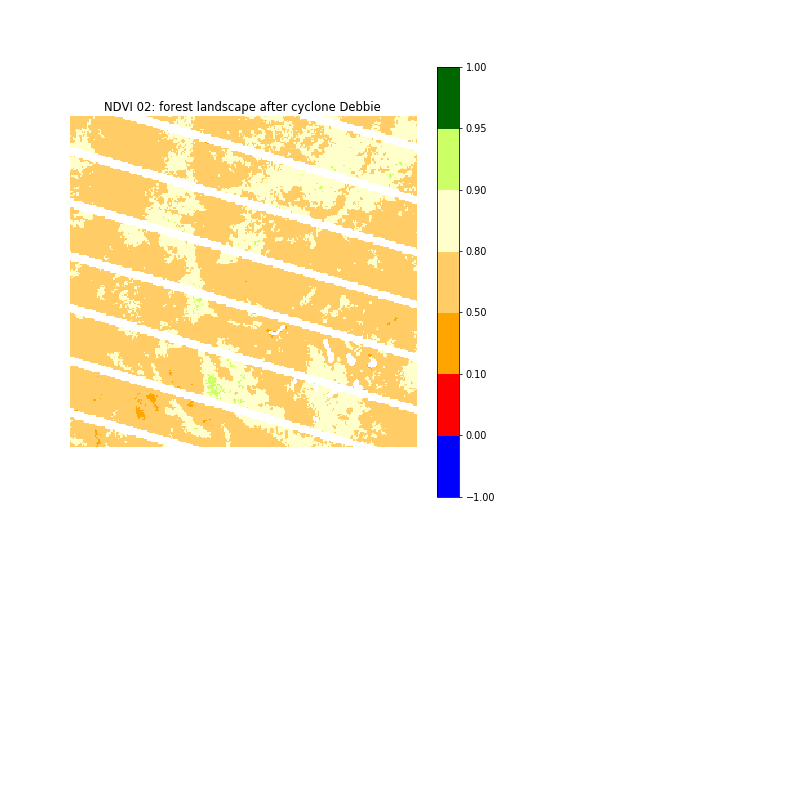

In [30]:
#Plot NDVI for scene after cyclone
fig = plt.figure(figsize=(8,8)) #create plot
plt.title('NDVI 02: ' + str(vegetation_type)+ ' landscape after cyclone '+ str(cyclone_name)) #add title
plt.axis('off')#remove axis
i=plt.imshow(ndvi02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colourbar

In [31]:
#Save figure
plt.savefig(str(output_folder)+'NDVI02_'+str(cyclone_name)+'_'+str(location_name))

# Change in vegetation before/after cyclone

In [32]:
#Calculate the difference in NDVI from before to after cyclone
ndvi_change= ndvi02-ndvi01
ndvi_change.attrs['affine'] = affine
# ndvi_change=(((ndvi_change-np.amin(ndvi_change))/(np.amax(ndvi_change)-np.amin(ndvi_change)))*100)

<IPython.core.display.Javascript object>


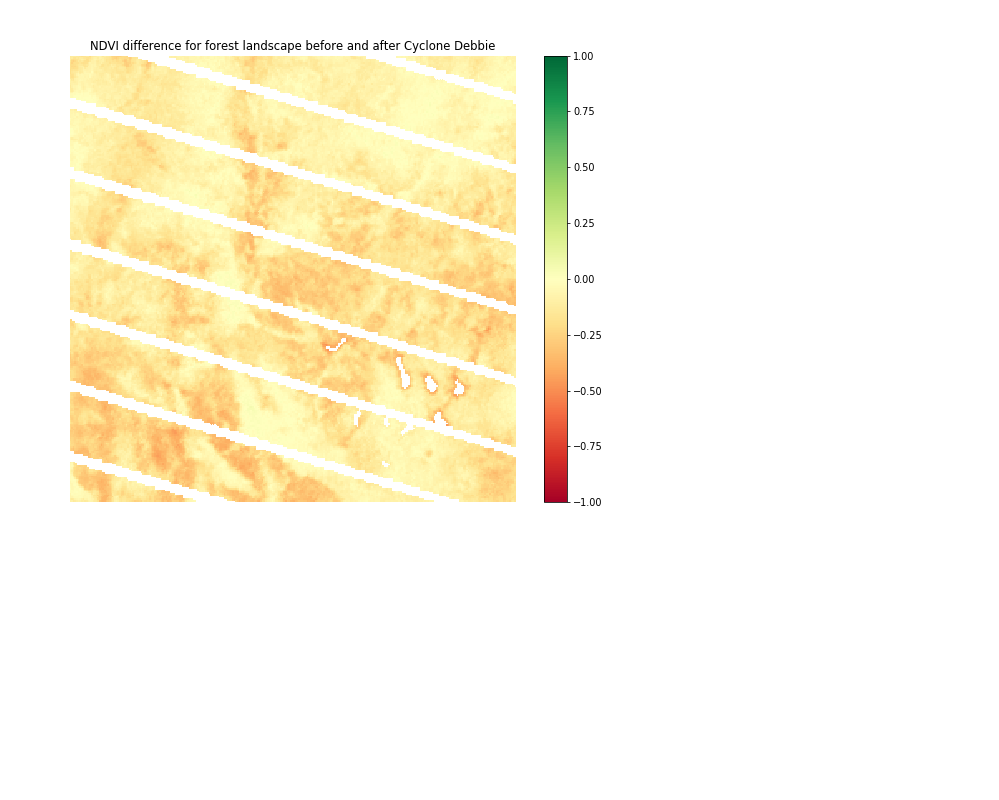

In [33]:
#Plot the change of NDVI
fig = plt.figure(figsize=(10,8)) #create plot
ndvi_change.plot(cmap = 'RdYlGn',vmin=-1,vmax=1) #create image
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10) #set border dimensions
fig.patch.set_facecolor('white') #make background white 
fig.patch.set_alpha(0.99)#ensure border white
plt.title('NDVI difference for '+str(vegetation_type)+ ' landscape before and after Cyclone '+str(cyclone_name)) #add title
plt.axis('off')#remove axis
plt.show() #show image

In [34]:
#Save figure
plt.savefig(str(output_folder)+'NDVI_change_'+str(cyclone_name)+'_'+str(location_name))

# Create animation that shows landscape before cyclone and then recovery of vegetation over time

In [35]:
nbar_clean=nbar_clean.drop('product')

In [37]:
animation_start=str(nbar_clean.sel(time=start_of_event, method = 'backfill').time.values)
animation_end=str(end_of_event+datetime.timedelta(days=400))
first_scene=str(nbar_clean.sel(time=start_of_event, method = 'pad').time.values)

nbar_animation=nbar_clean.sel(time=slice(animation_start,animation_end))
first_scene02=nbar_clean.sel(time=slice(first_scene,first_scene))

<IPython.core.display.Javascript object>


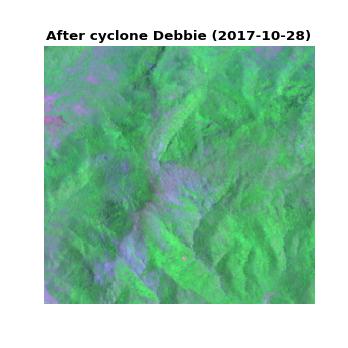

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [49]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_nbar=[]
data_to_plot_nbar =[]
first_scene_nbar=[]

for t  in range(0,np.shape(nbar_animation.time)[0]):
    time_slice = t
    times_to_plot_nbar.append(t)
    rgb = nbar_animation.isel(time =time_slice).to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    data_to_plot_nbar.append(scaled)

        
for t  in range(0,np.shape(first_scene02.time)[0]):
    time_slice = t
    times_to_plot_nbar.append(t)
    rgb = first_scene02.isel(time =time_slice).to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    first_scene_nbar.append(scaled)
        
        
fig1 = plt.figure(figsize =(5,5), dpi=100)    
time_text = plt.title(('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_nbar[0], interpolation = 'nearest', animated = True,)
plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_nbar[0])
    time_text.set_text('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_nbar[j])
    time_text.set_text('After cyclone '+str(cyclone_name)+' ('+ (str(nbar_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_nbar),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on

# Create NDVI animation

In [50]:
ndvi_animation_start=str(ndvi.sel(time=start_of_event, method = 'backfill').time.values)
ndvi_animation_end=str(end_of_event+datetime.timedelta(days=400))
ndvi_first_scene=str(ndvi.sel(time=start_of_event, method = 'pad').time.values)

ndvi_animation=ndvi.sel(time=slice(animation_start,animation_end))
ndvi_first_scene=ndvi.sel(time=slice(first_scene,first_scene))

In [51]:
ndvi_animation.isel(time =time_slice)

<xarray.DataArray (y: 257, x: 269)>
array([[ 0.732378,  0.736842,  0.729182, ...,  0.816906,  0.786379,  0.763079],
       [ 0.738809,  0.736842,  0.691441, ...,  0.793272,  0.773208,  0.763079],
       [ 0.757261,  0.673872,  0.662524, ...,  0.789224,  0.796078,  0.783455],
       ..., 
       [ 0.784906,  0.788398,  0.805341, ...,  0.73286 ,  0.691297,  0.704495],
       [ 0.756762,  0.733891,  0.749848, ...,  0.700941,  0.725694,  0.710526],
       [ 0.752121,  0.752137,  0.70798 , ...,  0.725694,  0.760161,  0.725103]])
Coordinates:
  * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
  * x        (x) float64 1.714e+06 1.714e+06 1.714e+06 1.714e+06 1.714e+06 ...
    time     datetime64[ns] 2017-04-11T00:07:09
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1713675.00|\n| 0.00,-25.00,-2279200.00|\n| 0.00,...

<IPython.core.display.Javascript object>


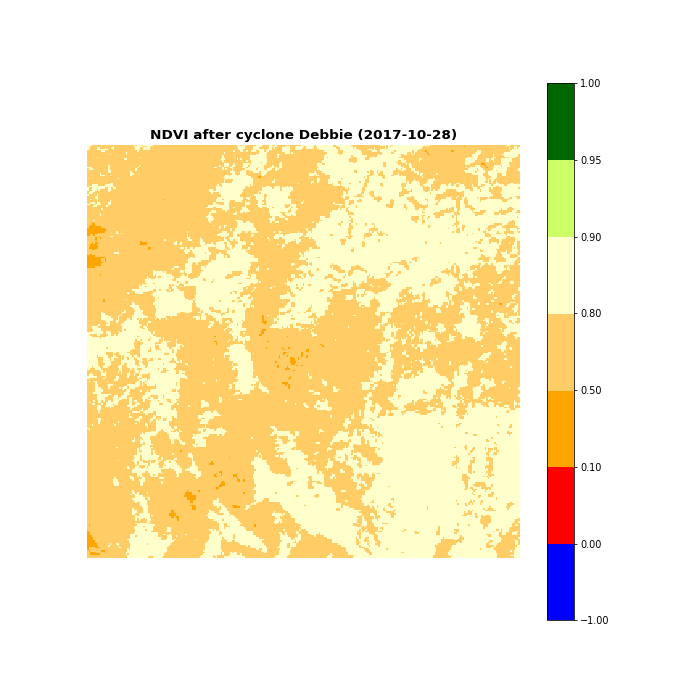

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [61]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_ndvi=[]
data_to_plot_ndvi =[]
first_scene_ndvi=[]
# good_data_threshold_nbar =.80

# def get_good_data_ratio(xyz, t):
#     total_pixels=np.shape(xyz.x)[0]*np.shape(xyz.y)[0]
#     total_data =np.count_nonzero((~np.isnan(xyz['nir'].isel(time=t))))
#     ratio = total_data/total_pixels
#     return ratio

for t  in range(0,np.shape(ndvi_animation.time)[0]):
    time_slice = t
    times_to_plot_ndvi.append(t)
    data_to_plot_ndvi.append(ndvi_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(ndvi_first_scene.time)[0]):
    time_slice = t
    times_to_plot_ndvi.append(t)
    first_scene_ndvi.append(ndvi_first_scene.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('NDVI before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
plt.axis('off')#remove axis
im = plt.imshow(first_scene_ndvi[0], interpolation = 'nearest', animated = True,cmap = ndvi_cmap, norm = ndvi_norm)
plt.colorbar(im) #add colourbar


#initilise the first frame of the animation
def init():
    im.set_data(first_scene_ndvi[0])
    time_text.set_text('NDVI before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_ndvi[j])
    time_text.set_text('NDVI after cyclone '+str(cyclone_name)+' ('+ (str(ndvi_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_ndvi),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [ ]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

In [ ]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

In [ ]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [ ]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [ ]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

# Save resampled windfield as an array and check array shape

In [ ]:
windfield_matched_array=windfield_matched.ReadAsArray()

print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

# Create a plot that examines relationship between wind and change in NDVI after a cyclone

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(windfield_matched_array, ndvi_change.values, 'ro') 
plt.axis([50 , 120 ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (km h$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after Cyclone '+str(cyclone_name)) #Set Y label

plt.show()

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'windfield_vs_NDVIchange'+str(cyclone_name)+'_'+str(location_name))